Modele final: prediction utilisant Designation et Descriptions Camemeber + VIT

In [1]:
import os

import importlib

import RktnChallenge.RktnModel
importlib.reload(RktnChallenge.RktnModel)
from RktnChallenge.RktnModel import ModelTrainer

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam,Adagrad
import numpy as np
import ast

2023-10-03 22:00:18.326531: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-03 22:00:18.350745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9511] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-03 22:00:18.350765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-03 22:00:18.350776: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-03 22:00:18.355875: I tensorflow/core/platform/cpu_feature_guar

In [2]:

# PARAMS  de base
PATH = "images/crop224/"
img_size = 224
depth = 3

from RktnChallenge.RktnModel import ModelTrainer

trainer = ModelTrainer("embeddings_final.csv",PATH)



In [3]:

list_tags = trainer.data.prdtypecode.unique().tolist()
num_categories = len(list_tags)





X_data = trainer.data[["embeddings_desi","embeddings_desc","embedding_vit","designation_length_normalized","description_length_normalized","embeddings_desi_Flaubert","embeddings_desc_Flaubert"]]

def convert_string_to_nparray(s):    
    # Supprime les caractères non désirés et divise la chaîne en une liste de nombres
    numbers = [float(x) for x in s.replace("[", "").replace("]", "").split()]
    return np.array(numbers)
def translate_string_to_array(s):
    liste_python = ast.literal_eval(s)
    return np.array(liste_python)

X_data.loc[:, 'embeddings_desc'] = X_data['embeddings_desc'].apply(convert_string_to_nparray)
X_data.loc[:, 'embeddings_desi'] = X_data['embeddings_desi'].apply(convert_string_to_nparray)
X_data.loc[:, 'embeddings_desi_Flaubert'] = X_data['embeddings_desi_Flaubert'].apply(convert_string_to_nparray)
X_data.loc[:, 'embeddings_desc_Flaubert'] = X_data['embeddings_desc_Flaubert'].apply(convert_string_to_nparray)

X_data.loc[:, 'embedding_vit'] = X_data['embedding_vit'].apply(translate_string_to_array)

y = trainer.encodeLabel("prdtypecode")
label_size = trainer.getLabelSize()


In [4]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size = 0.20, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)
X1_train = X_train["embeddings_desi"].values
X1_train = np.stack(X1_train).astype(np.float32)
X2_train = X_train["embeddings_desc"].values
X2_train = np.stack(X2_train).astype(np.float32)
X3_train = X_train["embedding_vit"].values
X3_train = np.stack(X3_train).astype(np.float32)
X4_train = X_train["designation_length_normalized"].values
X5_train = X_train["description_length_normalized"].values
X6_train = X_train["embeddings_desi_Flaubert"].values
X6_train = np.stack(X6_train).astype(np.float32)
X7_train = X_train["embeddings_desc_Flaubert"].values
X7_train = np.stack(X7_train).astype(np.float32)

X1_val = X_val["embeddings_desi"].values
X1_val = np.stack(X1_val).astype(np.float32)
X2_val = X_val["embeddings_desc"].values
X2_val = np.stack(X2_val).astype(np.float32)
X3_val = X_val["embedding_vit"].values
X3_val = np.stack(X3_val).astype(np.float32)
X4_val = X_val["designation_length_normalized"].values
X5_val = X_val["description_length_normalized"].values
X6_val = X_val["embeddings_desi_Flaubert"].values
X6_val = np.stack(X6_val).astype(np.float32)
X7_val = X_val["embeddings_desc_Flaubert"].values
X7_val = np.stack(X7_val).astype(np.float32)


X1_test = X_test["embeddings_desi"].values
X1_test = np.stack(X1_test).astype(np.float32)
X2_test = X_test["embeddings_desc"].values
X2_test = np.stack(X2_test).astype(np.float32)
X3_test = X_test["embedding_vit"].values
X3_test = np.stack(X3_test).astype(np.float32)
X4_test = X_test["designation_length_normalized"].values
X5_test = X_test["description_length_normalized"].values
X6_test = X_test["embeddings_desi_Flaubert"].values
X6_test = np.stack(X6_test).astype(np.float32)
X7_test = X_test["embeddings_desi_Flaubert"].values
X7_test = np.stack(X7_test).astype(np.float32)

#del X_data
del X_test
del X_train

In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_weighted(true, pred):  
    # Classes
    classes = K.arange(0, 27) 
    true = K.one_hot(K.cast(true, 'int32'), 27)
    
    # Calcule les TP, FP, FN pour chaque classe
    tp = K.dot(K.transpose(true), K.round(pred))
    fp = K.dot(K.transpose(1-true), K.round(pred))
    fn = K.dot(K.transpose(true), 1-K.round(pred))

    # Calcule le score F1 pour chaque classe
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f1 = 2*p*r / (p+r+K.epsilon())

    # Calculez le score F1 moyen pondéré
    weighted_f1 = K.sum(f1 * K.sum(true, axis=0) / K.sum(true))
    return weighted_f1


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW,RMSprop

input_1 = Input(shape=(768,), name="input_1")
input_2 = Input(shape=(768,), name="input_2")
input_3 = Input(shape=(768,), name="input_3")
input_4 = Input(shape=(1,), name="input_4")
input_5 = Input(shape=(1,), name="input_5")
input_6 = Input(shape=(768,), name="input_6")
#input_7 = Input(shape=(768,), name="input_7")

# Concaténer les deux entrées
merged = Concatenate(axis=1)([input_1, input_2,input_3, input_4,input_5,input_6])

x = Dense(1024, activation='selu')(merged)
x = Dropout(0.1)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
output = Dense(27, activation='softmax')(x)
#optimizer = Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
#optimizer = AdamW(weight_decay=0.01, learning_rate=1e-5, epsilon=1e-08, clipnorm=1.0) 
optimizer = RMSprop(learning_rate=1e-3)
model = Model(inputs=[input_1, input_2,input_3,input_4,input_5,input_6], outputs=output)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy',f1_weighted])

model.summary()


2023-10-03 22:05:51.631609: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-03 22:05:51.907117: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-03 22:05:51.907327: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-03 22:05:51.909392: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                              

2023-10-03 22:05:51.909682: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-03 22:05:51.909918: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-03 22:05:52.519436: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-03 22:05:52.519831: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-03 22:05:52.519845: I tensorflow/core/common

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Lambda,Multiply
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import AdamW

input_1 = Input(shape=(768,), name="input_1")
input_2 = Input(shape=(768,), name="input_2")
input_3 = Input(shape=(768,), name="input_3")


# Le merge des  towers
# Poids pour la moyenne pondérée
w_i1 = tf.Variable(initial_value=tf.ones([768])*0.5, trainable=True, dtype=tf.float32) # initialisé à 0.5, mais entraînable
w_i2 = tf.Variable(initial_value=tf.ones([768])*0.5, trainable=True, dtype=tf.float32) # initialisé à 0.5, mais entraînable

w_i3 = tf.Variable(initial_value=tf.ones([768])*0.5, trainable=True, dtype=tf.float32) # initialisé à 0.5, mais entraînable

w_i4 = tf.Variable(initial_value=tf.zeros([768]), trainable=True, dtype=tf.float32)

# Fusion moyenne pondérée
moyenne = Lambda(lambda features: w_i1 * features[0] + w_i2 * features[1] + w_i3*features[2]+w_i4)([input_1, input_2, input_3])

#produit = Multiply()([input_1, input_2])
#difference = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([input_1, input_2])


#merged = Concatenate(axis=1)([input_1, input_2])

x = Dense(512, activation='relu')(moyenne)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(27, activation='softmax')(x)

model = Model(inputs=[input_1, input_2, input_3], outputs=output)
optimizer = AdamW(weight_decay=0.01, learning_rate=1e-5, epsilon=1e-08, clipnorm=1.0) 
#optimizer = Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(768,) dtype=float32>
  <tf.Variable 'Variable:0' shape=(768,) dtype=float32>
  <tf.Variable 'Variable:0' shape=(768,) dtype=float32>
  <tf.Variable 'Variable:0' shape=(768,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 lambda (Lambda)             (None, 768)                  0         ['input_1[0][0]',             
                                                                     'input_2[0][0]',       

In [68]:


early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='auto', patience=6, 
            verbose=1, restore_best_weights=True
        ) 

model.fit([X1_train, X2_train, X3_train, X4_train, X5_train, X6_train], y_train, epochs=30, batch_size=32, validation_data=([X1_val, X2_val,X3_val,X4_val,X5_val,X6_val], y_val),callbacks=[early_stopper])

Epoch 1/30
  27/1699 [..............................] - ETA: 10s - loss: 0.0286 - accuracy: 0.9896 - f1_weighted: 0.9947  

2023-09-26 15:24:35.533528: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1692/1699 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.9940 - f1_weighted: 0.9968

2023-09-26 15:24:45.854695: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1699/1699 [==============================] - 12s 7ms/step - loss: 0.0217 - accuracy: 0.9940 - f1_weighted: 0.9968 - val_loss: 0.6297 - val_accuracy: 0.9425 - val_f1_weighted: 0.9712
Epoch 2/30
1699/1699 [==============================] - 12s 7ms/step - loss: 0.0218 - accuracy: 0.9943 - f1_weighted: 0.9971 - val_loss: 0.6561 - val_accuracy: 0.9424 - val_f1_weighted: 0.9719
Epoch 3/30
1699/1699 [==============================] - 12s 7ms/step - loss: 0.0188 - accuracy: 0.9951 - f1_weighted: 0.9976 - val_loss: 0.6641 - val_accuracy: 0.9418 - val_f1_weighted: 0.9716
Epoch 4/30
1699/1699 [==============================] - 12s 7ms/step - loss: 0.0184 - accuracy: 0.9951 - f1_weighted: 0.9976 - val_loss: 0.6855 - val_accuracy: 0.9430 - val_f1_weighted: 0.9722
Epoch 5/30
1699/1699 [==============================] - 11s 7ms/step - loss: 0.0184 - accuracy: 0.9948 - f1_weighted: 0.9973 - val_loss: 0.7123 - val_accuracy: 0.9447 - val_f1_weighted: 0.9729
Epoch 6/30
1699/1699 [========================

 67/531 [==>...........................] - ETA: 1s

2023-09-26 15:27:07.190094: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 1s 2ms/step
weighted F1 score: 0.8976574332554619


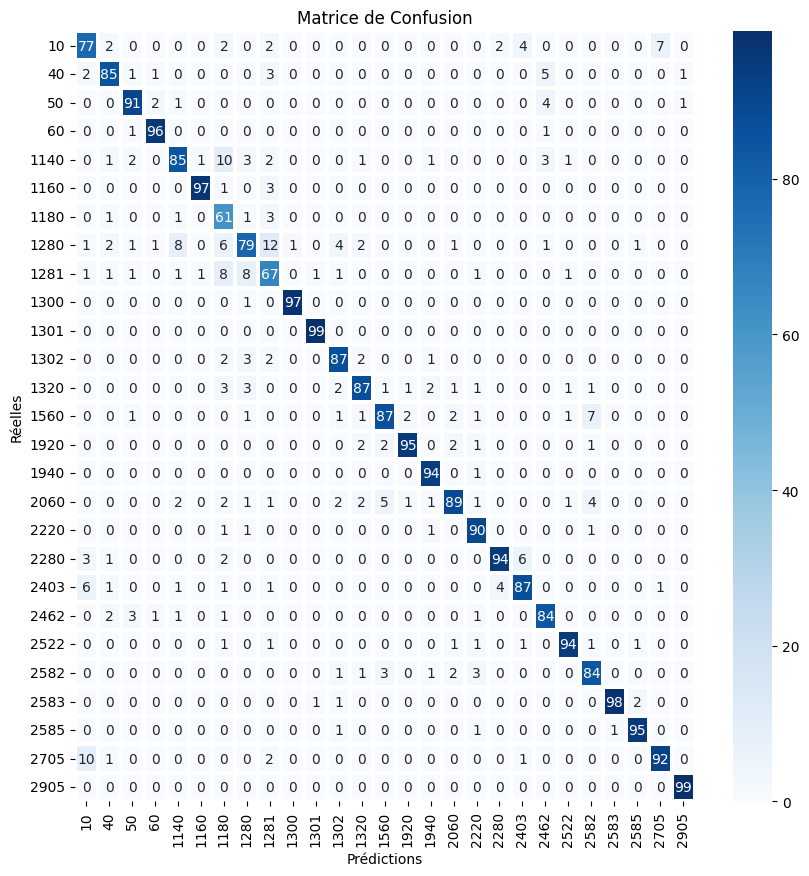

In [69]:
#avec flaubert_desi
y_pred = model.predict([X1_test, X2_test,X3_test,X4_test,X5_test,X6_test])
y_pred_ids = np.argmax(y_pred, axis=-1)

trainer.evaluateTestResults(y_test,y_pred_ids)

 77/531 [===>..........................] - ETA: 0s

2023-09-25 15:41:28.581417: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 1s 2ms/step
weighted F1 score: 0.9009152885861007


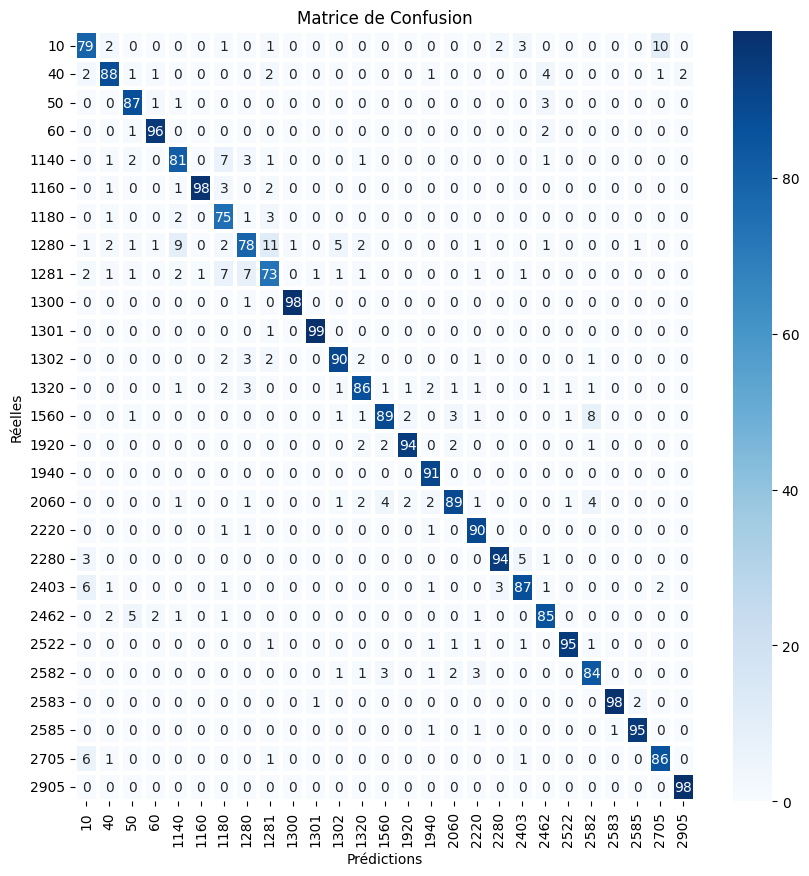

In [26]:
#avec flaubert_desi
y_pred = model.predict([X1_test, X2_test,X3_test,X4_test,X5_test,X6_test,X7_test])
y_pred_ids = np.argmax(y_pred, axis=-1)

trainer.evaluateTestResults(y_test,y_pred_ids)

In [13]:
early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='auto', patience=2, 
            verbose=1, restore_best_weights=True
        ) 

model.fit([X1_train, X2_train, X3_train], y_train, epochs=10, batch_size=10, validation_data=([X1_val, X2_val,X3_val], y_val),callbacks=[early_stopper])

Epoch 1/10
  26/5435 [..............................] - ETA: 34s - loss: 0.1079 - accuracy: 0.9654

2023-09-25 11:34:52.936126: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



5427/5435 [============================>.] - ETA: 0s - loss: 0.0557 - accuracy: 0.9845

2023-09-25 11:35:24.270413: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



5435/5435 [==============================] - 35s 6ms/step - loss: 0.0557 - accuracy: 0.9845 - val_loss: 0.2507 - val_accuracy: 0.9451
Epoch 2/10
5435/5435 [==============================] - 34s 6ms/step - loss: 0.0534 - accuracy: 0.9847 - val_loss: 0.2515 - val_accuracy: 0.9453
Epoch 3/10
5435/5435 [==============================] - 33s 6ms/step - loss: 0.0529 - accuracy: 0.9845 - val_loss: 0.2536 - val_accuracy: 0.9458
Epoch 4/10
5435/5435 [==============================] - 33s 6ms/step - loss: 0.0493 - accuracy: 0.9860 - val_loss: 0.2539 - val_accuracy: 0.9458
Epoch 5/10
5435/5435 [==============================] - 40s 7ms/step - loss: 0.0502 - accuracy: 0.9857 - val_loss: 0.2548 - val_accuracy: 0.9464
Epoch 6/10
5435/5435 [==============================] - 34s 6ms/step - loss: 0.0472 - accuracy: 0.9872 - val_loss: 0.2555 - val_accuracy: 0.9464
Epoch 7/10
5435/5435 [==============================] - 35s 6ms/step - loss: 0.0477 - accuracy: 0.9869 - val_loss: 0.2562 - val_accuracy: 0.9

 65/531 [==>...........................] - ETA: 1s

2023-09-25 11:42:08.468743: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 1s 2ms/step
weighted F1 score: 0.8983780560585773


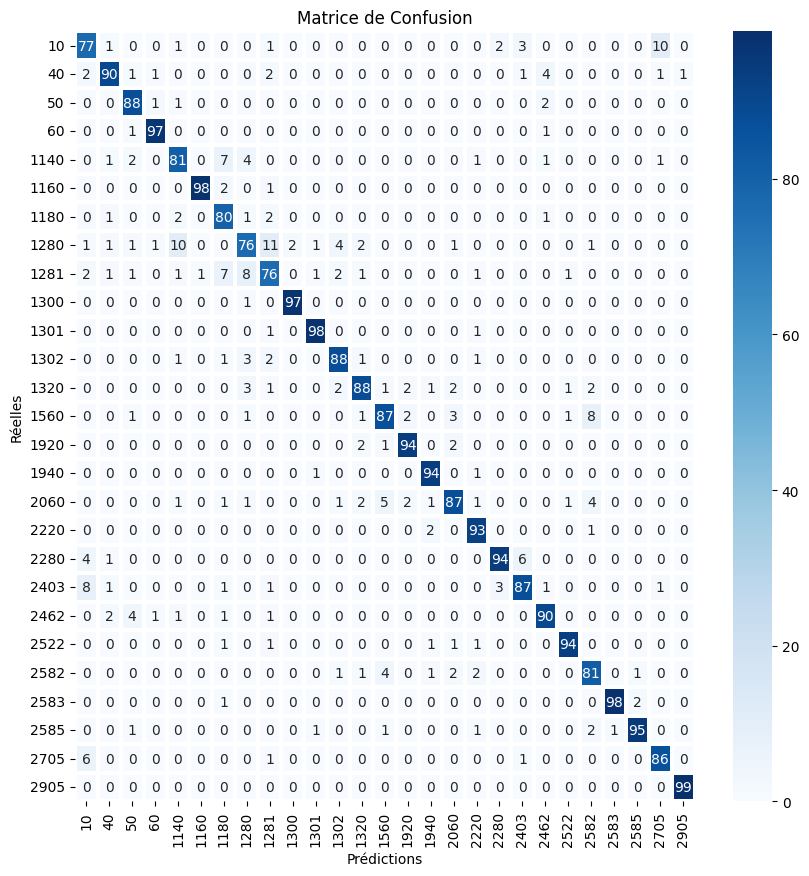

In [14]:
y_pred = model.predict([X1_test, X2_test,X3_test])
y_pred_ids = np.argmax(y_pred, axis=-1)

trainer.evaluateTestResults(y_test,y_pred_ids)

 66/531 [==>...........................] - ETA: 1s

2023-09-25 11:19:00.656789: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 1s 2ms/step
weighted F1 score: 0.8980423462541249


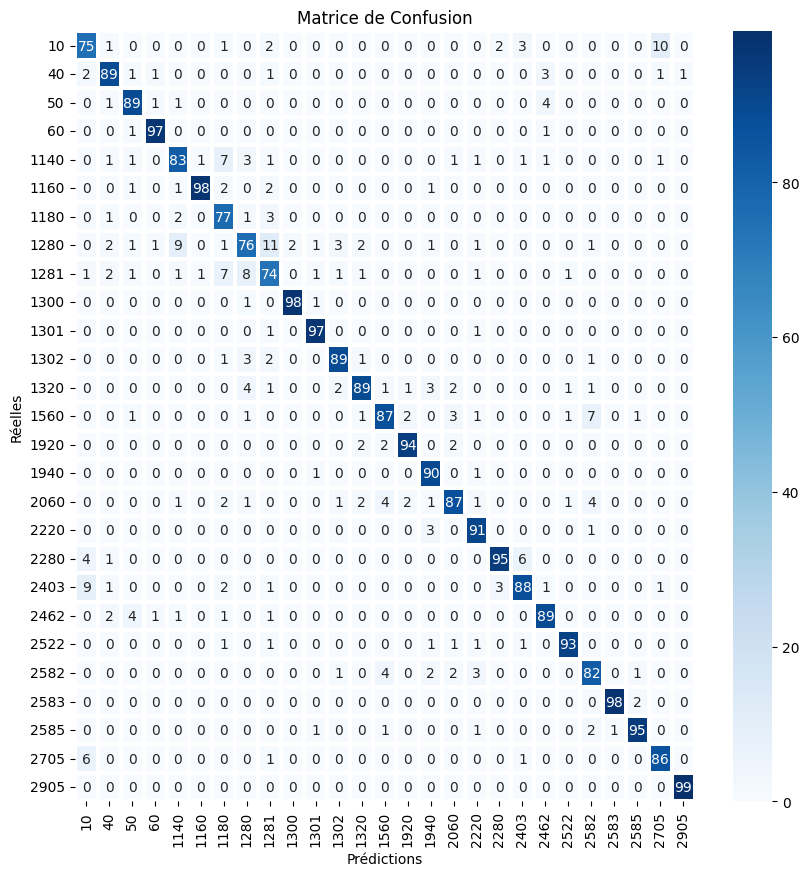

In [8]:
y_pred = model.predict([X1_test, X2_test,X3_test,X4_test,X5_test])
y_pred_ids = np.argmax(y_pred, axis=-1)

trainer.evaluateTestResults(y_test,y_pred_ids)

 34/531 [>.............................] - ETA: 1s

2023-09-14 13:59:23.367817: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 2s 3ms/step
weighted F1 score: 0.8878551331939717


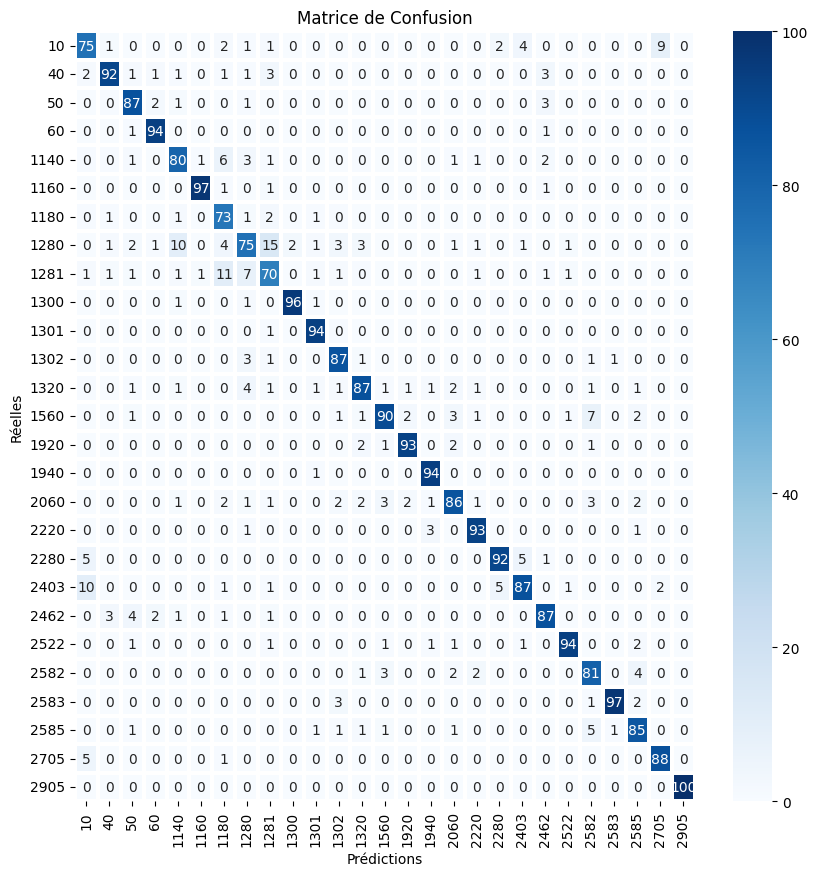

In [6]:
y_pred = model.predict([X1_test, X2_test,X3_test,X4_test,X5_test])
y_pred_ids = np.argmax(y_pred, axis=-1)

trainer.evaluateTestResults(y_test,y_pred_ids)

 49/531 [=>............................] - ETA: 1s

2023-09-14 00:00:42.151188: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 1s 2ms/step
weighted F1 score: 0.884816790453571


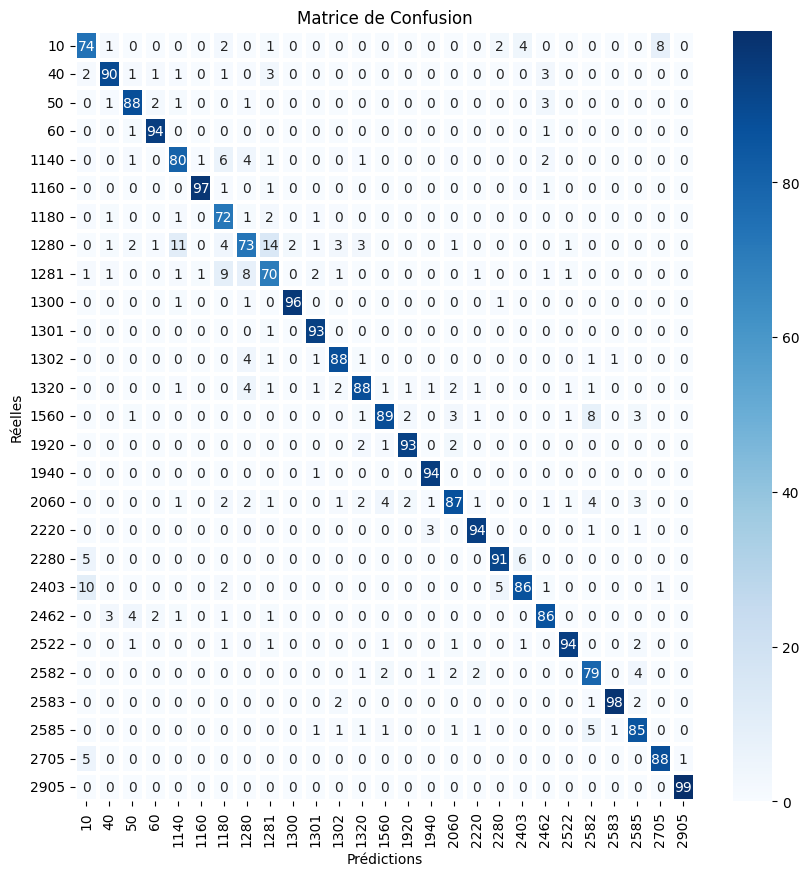

In [47]:
y_pred = model.predict([X1_test, X2_test,X3_test])
y_pred_ids = np.argmax(y_pred, axis=-1)

trainer.evaluateTestResults(y_test,y_pred_ids)